# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-oahiq0__
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-oahiq0__
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
    

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

## Load Model

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# get preds fn

In [6]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

In [7]:
def get_top_preds(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
) -> None:
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    return logits[index-1, sorted_token_values[:top_k]], sorted_token_probs[:top_k], [model.to_string(tok) for tok in sorted_token_values[:top_k]]

# Numeric, decr

In [ ]:
example_prompt = "5 4 3 2"
example_answer = " 1"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '5', ' 4', ' 3', ' 2']
Tokenized answer: [' 1']


Performance on answer token:
Rank: 0        Logit: 17.47 Prob: 48.35% Token: | 1|

Top 0th token. Logit: 17.47 Prob: 48.35% Token: | 1|
Top 1th token. Logit: 16.10 Prob: 12.34% Token: | 2|
Top 2th token. Logit: 15.90 Prob: 10.12% Token: | 0|
Top 3th token. Logit: 15.43 Prob:  6.31% Token: | 3|
Top 4th token. Logit: 14.73 Prob:  3.14% Token: |
|
Top 5th token. Logit: 14.32 Prob:  2.07% Token: |.|
Top 6th token. Logit: 13.90 Prob:  1.36% Token: | 5|
Top 7th token. Logit: 13.82 Prob:  1.26% Token: | 4|
Top 8th token. Logit: 13.80 Prob:  1.24% Token: | .|
Top 9th token. Logit: 13.48 Prob:  0.90% Token: | -|


Ranks of the answer tokens: [(' 1', 0)]

In [ ]:
# for every prompt, get its top token. find which top tokens are S4 + 1

prompt = "1 second passed. Then 2 seconds. Next 3 seconds. Then 4 seconds. Finally"
answer = " 5"

logs, probs, toks = get_top_preds(
    prompt = prompt,
    answer = answer,
    model = model,
)
logs

tensor([15.9796, 15.9074, 15.6687, 15.5836, 15.4298, 15.2030, 14.5341, 14.2668,
        14.0130, 13.8063])

In [ ]:
toks

[' 5', ',', ' 4', ' 3', ' 2', ' 1', ' 6', '.', ' 10', ' a']

In [ ]:
toks.index(' 4')

2

In [ ]:
incor_ind = toks.index(' 4')
logs[0] - logs[incor_ind]

tensor(0.3109)

In [ ]:
prompt = "1 second passed. Then 2 seconds. Next 3 seconds. Then 4 seconds. Finally"
answer = " 5"
utils.test_prompt(prompt, answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' second', ' passed', '.', ' Then', ' 2', ' seconds', '.', ' Next', ' 3', ' seconds', '.', ' Then', ' 4', ' seconds', '.', ' Finally']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 15.98 Prob: 15.30% Token: | 5|

Top 0th token. Logit: 15.98 Prob: 15.30% Token: | 5|
Top 1th token. Logit: 15.91 Prob: 14.23% Token: |,|
Top 2th token. Logit: 15.67 Prob: 11.21% Token: | 4|
Top 3th token. Logit: 15.58 Prob: 10.30% Token: | 3|
Top 4th token. Logit: 15.43 Prob:  8.83% Token: | 2|
Top 5th token. Logit: 15.20 Prob:  7.04% Token: | 1|
Top 6th token. Logit: 14.53 Prob:  3.60% Token: | 6|
Top 7th token. Logit: 14.27 Prob:  2.76% Token: |.|
Top 8th token. Logit: 14.01 Prob:  2.14% Token: | 10|
Top 9th token. Logit: 13.81 Prob:  1.74% Token: | a|


Ranks of the answer tokens: [(' 5', 0)]

In [ ]:
prompt = "1 second passed. Then 2. Next 3 seconds passed. Then 4 seconds. Finally"
answer = " 5"
utils.test_prompt(prompt, answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' second', ' passed', '.', ' Then', ' 2', '.', ' Next', ' 3', ' seconds', ' passed', '.', ' Then', ' 4', ' seconds', '.', ' Finally']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 16.09 Prob: 31.66% Token: | 5|

Top 0th token. Logit: 16.09 Prob: 31.66% Token: | 5|
Top 1th token. Logit: 15.19 Prob: 12.77% Token: |,|
Top 2th token. Logit: 14.48 Prob:  6.31% Token: | 4|
Top 3th token. Logit: 14.22 Prob:  4.86% Token: | 1|
Top 4th token. Logit: 14.17 Prob:  4.63% Token: | 6|
Top 5th token. Logit: 14.10 Prob:  4.29% Token: | 3|
Top 6th token. Logit: 13.90 Prob:  3.53% Token: | 2|
Top 7th token. Logit: 13.70 Prob:  2.88% Token: |.|
Top 8th token. Logit: 13.25 Prob:  1.85% Token: | 10|
Top 9th token. Logit: 13.20 Prob:  1.75% Token: | a|


Ranks of the answer tokens: [(' 5', 0)]

# dataset 100 samps

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'incor': f" {i+3}",
            'text': f"{i} seconds passed. Then {i+1} seconds. Next {i+2} seconds. Then {i+3} seconds. Finally",
            'answer': f" {i+4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(2, 101)

In [ ]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks = get_top_preds(
        prompt = prompt,
        answer = answer,
        model = model,
    )
    if toks[0] == answer:
        print(f"{prompt} -> {answer}", toks[0])
        incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        print(l_diff.item())
        good_prompts.append(prompt)

4 seconds passed. Then 5 seconds. Next 6 seconds. Then 7 seconds. Finally ->  8  8
0.6241788864135742
5 seconds passed. Then 6 seconds. Next 7 seconds. Then 8 seconds. Finally ->  9  9
1.0272293090820312
6 seconds passed. Then 7 seconds. Next 8 seconds. Then 9 seconds. Finally ->  10  10
0.9744157791137695
7 seconds passed. Then 8 seconds. Next 9 seconds. Then 10 seconds. Finally ->  11  11
0.24978256225585938
8 seconds passed. Then 9 seconds. Next 10 seconds. Then 11 seconds. Finally ->  12  12
1.3463668823242188
9 seconds passed. Then 10 seconds. Next 11 seconds. Then 12 seconds. Finally ->  13  13
0.9000473022460938
10 seconds passed. Then 11 seconds. Next 12 seconds. Then 13 seconds. Finally ->  14  14
1.3127861022949219
11 seconds passed. Then 12 seconds. Next 13 seconds. Then 14 seconds. Finally ->  15  15
2.04351806640625
12 seconds passed. Then 13 seconds. Next 14 seconds. Then 15 seconds. Finally ->  16  16
1.7002592086791992
13 seconds passed. Then 14 seconds. Next 15 seconds

In [ ]:
len(good_prompts) / len(prompts_list)

0.8585858585858586

Text(0.5, 1.0, 'Distribution of logit_diffs')

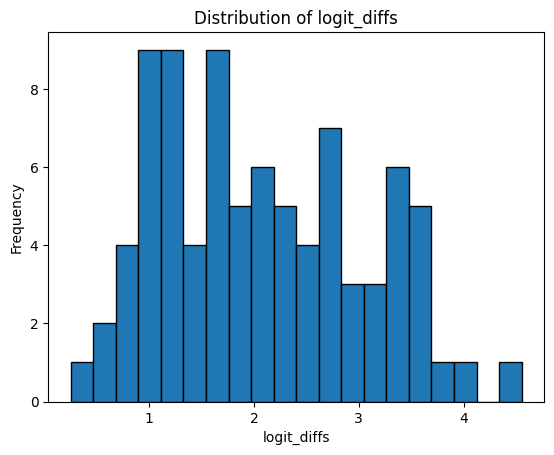

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# dataset 1000 samps

In [8]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'incor': f" {i+3}",
            'text': f"{i} seconds passed. Then {i+1} seconds. Next {i+2} seconds. Then {i+3} seconds. Finally",
            'answer': f" {i+4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(2, 1001)

Modify this so incorr logit can be found in top k

In [13]:
def get_top_preds_moredata(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    incor: str,
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
):
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    k = top_k
    while k < 500:
        toks = [model.to_string(tok) for tok in sorted_token_values[:k]]
        if incor in toks:
            incor_ind = toks.index(incor)
            break
        else:
            k += 50
            print(k)

    if k < 500:
        return logits[index-1, sorted_token_values[:k]], sorted_token_probs[:k], toks, incor_ind
    else:
        return [], [], [], 'cont'

In [14]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    if toks[0] == answer:
        print(f"{prompt} -> {answer}")
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt)

4 seconds passed. Then 5 seconds. Next 6 seconds. Then 7 seconds. Finally ->  8
5 seconds passed. Then 6 seconds. Next 7 seconds. Then 8 seconds. Finally ->  9
6 seconds passed. Then 7 seconds. Next 8 seconds. Then 9 seconds. Finally ->  10
7 seconds passed. Then 8 seconds. Next 9 seconds. Then 10 seconds. Finally ->  11
8 seconds passed. Then 9 seconds. Next 10 seconds. Then 11 seconds. Finally ->  12
9 seconds passed. Then 10 seconds. Next 11 seconds. Then 12 seconds. Finally ->  13
10 seconds passed. Then 11 seconds. Next 12 seconds. Then 13 seconds. Finally ->  14
11 seconds passed. Then 12 seconds. Next 13 seconds. Then 14 seconds. Finally ->  15
12 seconds passed. Then 13 seconds. Next 14 seconds. Then 15 seconds. Finally ->  16
13 seconds passed. Then 14 seconds. Next 15 seconds. Then 16 seconds. Finally ->  17
14 seconds passed. Then 15 seconds. Next 16 seconds. Then 17 seconds. Finally ->  18
15 seconds passed. Then 16 seconds. Next 17 seconds. Then 18 seconds. Finally ->  19


KeyboardInterrupt: ignored

In [15]:
len(good_prompts) / len(prompts_list)

0.38538538538538536

In [16]:
good_prompts[-10:]

['425 seconds passed. Then 426 seconds. Next 427 seconds. Then 428 seconds. Finally',
 '426 seconds passed. Then 427 seconds. Next 428 seconds. Then 429 seconds. Finally',
 '432 seconds passed. Then 433 seconds. Next 434 seconds. Then 435 seconds. Finally',
 '441 seconds passed. Then 442 seconds. Next 443 seconds. Then 444 seconds. Finally',
 '497 seconds passed. Then 498 seconds. Next 499 seconds. Then 500 seconds. Finally',
 '498 seconds passed. Then 499 seconds. Next 500 seconds. Then 501 seconds. Finally',
 '499 seconds passed. Then 500 seconds. Next 501 seconds. Then 502 seconds. Finally',
 '500 seconds passed. Then 501 seconds. Next 502 seconds. Then 503 seconds. Finally',
 '501 seconds passed. Then 502 seconds. Next 503 seconds. Then 504 seconds. Finally',
 '698 seconds passed. Then 699 seconds. Next 700 seconds. Then 701 seconds. Finally']

Text(0.5, 1.0, 'Distribution of logit_diffs')

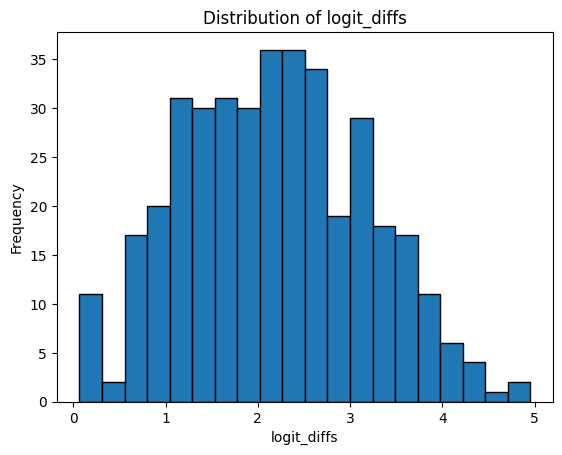

In [17]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# dataset 1000 samps

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'incor': f" {i+3}",
            'text': f"{i} seconds passed. Then {i+1} seconds. Next {i+2} seconds. Then {i+3} seconds. Finally",
            'answer': f" {i+4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(2, 501)

Modify this so incorr logit can be found in top k

In [32]:
def get_top_preds_moredata(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    incor: str,
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
):
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    k = top_k
    while k < 500:
        toks = [model.to_string(tok) for tok in sorted_token_values[:k]]
        if incor in toks:
            incor_ind = toks.index(incor)
            break
        else:
            k += 50
            # print(k)

    if k < 500:
        return logits[index-1, sorted_token_values[:k]], sorted_token_probs[:k], toks, incor_ind
    else:
        return [], [], [], 'cont'

In [ ]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    if toks[0] == answer:
        print(f"{prompt} -> {answer}")
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt)

In [ ]:
len(good_prompts) / len(prompts_list)

0.38538538538538536

In [ ]:
good_prompts[-10:]

['425 seconds passed. Then 426 seconds. Next 427 seconds. Then 428 seconds. Finally',
 '426 seconds passed. Then 427 seconds. Next 428 seconds. Then 429 seconds. Finally',
 '432 seconds passed. Then 433 seconds. Next 434 seconds. Then 435 seconds. Finally',
 '441 seconds passed. Then 442 seconds. Next 443 seconds. Then 444 seconds. Finally',
 '497 seconds passed. Then 498 seconds. Next 499 seconds. Then 500 seconds. Finally',
 '498 seconds passed. Then 499 seconds. Next 500 seconds. Then 501 seconds. Finally',
 '499 seconds passed. Then 500 seconds. Next 501 seconds. Then 502 seconds. Finally',
 '500 seconds passed. Then 501 seconds. Next 502 seconds. Then 503 seconds. Finally',
 '501 seconds passed. Then 502 seconds. Next 503 seconds. Then 504 seconds. Finally',
 '698 seconds passed. Then 699 seconds. Next 700 seconds. Then 701 seconds. Finally']

Text(0.5, 1.0, 'Distribution of logit_diffs')

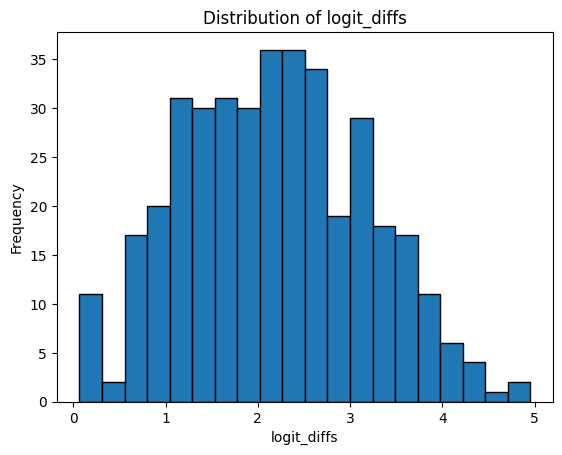

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# auto find prompts that work

# random words same interval

In [18]:
# https://bobbyhadz.com/blog/python-generate-random-word
import random
import requests

def get_list_of_words():
    response = requests.get(
        'https://www.mit.edu/~ecprice/wordlist.10000',
        timeout=10
    )

    string_of_words = response.content.decode('utf-8')

    list_of_words = string_of_words.splitlines()

    return list_of_words

words = get_list_of_words()
print(len(words))

random_word = random.choice(words)
print(random_word)  # 👉️ zoo

10000
relationship


In [19]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
words = filter_to_single_token(words)
len(words)

3266

In [49]:
def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        # for j in range(30):
        for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'incor': f" {i+3}",
                'text': f"{rand_words[0]} {i} {rand_words[1]} {i+1} {rand_words[2]} {i+2} {rand_words[3]} {i+3} {rand_words[4]}",
                'answer': f" {i+4}"
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 501, words)

In [50]:
len(prompts_list)

1000

In [22]:
# def make_prompts(names, template, corrupted_template, num_sentences, num_rand):
#     sentences = []
#     corr_sentences = []
#     generated_set = set() # Ensure none of the generated sentences are the same
#     while len(sentences) < num_sentences:
#         unique_names = random.sample(names, k=num_rand)
#         temp_template = template
#         temp_corr_template = corrupted_template
#         for i, name in enumerate(unique_names, start=1):
#             temp_template = temp_template.replace(f"[S{i}]", name)
#             temp_corr_template = temp_corr_template.replace(f"[S{i}]", name)

#         # tokenzier seems to work differently when tokens used with other tokens?
#         if len(model.to_str_tokens(temp_template)) == (len(template.split(' ')) + template.count('.') + 1) :  #1 for endoftext token
#             if temp_template not in generated_set:
#                 generated_set.add(temp_template)
#                 sentences.append(temp_template)
#                 corr_sentences.append(temp_corr_template)
#     return sentences, corr_sentences

# template = "[S1] 1 [S2] 2 [S3] 3 [S4] 4 [S5]"
# corrupted_template = "[S1] 1 [S2] 2 [S3] 3 [S4] 4 [S5]"
# N = 15000
# prompts_list, corrupted_prompts = make_prompts(words, template, corrupted_template, N, num_rand=5)
# prompts_list[:5]

['meta 1 str 2 play 3 does 4 variable',
 'over 1 finding 2 margin 3 walk 4 render',
 'su 1 reason 2 direct 3 pen 4 ga',
 'married 1 final 2 broken 3 story 4 missions',
 'dh 1 runs 2 dump 3 st 4 bus']

In [51]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    if toks[0] == answer:
        # print(f"{prompt} -> {answer}")
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt)
        if len(good_prompts) == 10000:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [52]:
good_prompts[-10:]

['apps 424 rica 425 dir 426 wall 427 ever',
 'worn 426 sort 427 severe 428 div 429 dos',
 'duration 426 mental 427 tech 428 shots 429 comfort',
 'von 441 song 442 strap 443 lite 444 famous',
 'colour 454 n 455 breaking 456 roman 457 unknown',
 'alien 497 built 498 classified 499 centered 500 width',
 'tn 498 pub 499 ink 500 success 501 space',
 'quality 499 nuts 500 fun 501 loaded 502 male',
 'apache 499 wy 500 marks 501 chip 502 inside',
 'stones 500 s 501 data 502 effective 503 bowl']

In [53]:
probs

tensor([0.0993, 0.0435, 0.0363, 0.0329, 0.0243, 0.0199, 0.0198, 0.0155, 0.0145,
        0.0132], device='cuda:0')

In [55]:
prompts_list[100]

{'incor': ' 54',
 'text': 'nuclear 51 style 52 she 53 view 54 gm',
 'answer': ' 55'}

In [56]:
example_prompt = 'nuclear 51 style 52 she 53 view 54 gm'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'nuclear', ' 51', ' style', ' 52', ' she', ' 53', ' view', ' 54', ' g', 'm']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 0        Logit: 14.64 Prob: 58.51% Token: | 55|

Top 0th token. Logit: 14.64 Prob: 58.51% Token: | 55|
Top 1th token. Logit: 12.03 Prob:  4.29% Token: | 56|
Top 2th token. Logit: 11.98 Prob:  4.09% Token: |55|
Top 3th token. Logit: 11.73 Prob:  3.20% Token: | 54|
Top 4th token. Logit: 10.65 Prob:  1.09% Token: | 5|
Top 5th token. Logit: 10.40 Prob:  0.84% Token: | 35|
Top 6th token. Logit: 10.38 Prob:  0.83% Token: | 60|
Top 7th token. Logit: 10.32 Prob:  0.78% Token: | 65|
Top 8th token. Logit: 10.21 Prob:  0.70% Token: | 45|
Top 9th token. Logit: 10.06 Prob:  0.60% Token: | 53|


Ranks of the answer tokens: [(' 55', 0)]

In [57]:
example_prompt = '51 days 52 days 53 days 54 days'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '51', ' days', ' 52', ' days', ' 53', ' days', ' 54', ' days']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 0        Logit: 21.74 Prob: 94.65% Token: | 55|

Top 0th token. Logit: 21.74 Prob: 94.65% Token: | 55|
Top 1th token. Logit: 17.45 Prob:  1.30% Token: | 56|
Top 2th token. Logit: 16.96 Prob:  0.80% Token: | 5|
Top 3th token. Logit: 16.28 Prob:  0.40% Token: | 54|
Top 4th token. Logit: 15.83 Prob:  0.26% Token: | 60|
Top 5th token. Logit: 15.68 Prob:  0.22% Token: | 555|
Top 6th token. Logit: 15.50 Prob:  0.18% Token: | 57|
Top 7th token. Logit: 15.46 Prob:  0.18% Token: | 65|
Top 8th token. Logit: 15.15 Prob:  0.13% Token: | 75|
Top 9th token. Logit: 15.11 Prob:  0.13% Token: |
|


Ranks of the answer tokens: [(' 55', 0)]

In [58]:
example_prompt = '51 days 52 months 53 weeks 54 minutes'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '51', ' days', ' 52', ' months', ' 53', ' weeks', ' 54', ' minutes']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 1        Logit: 17.44 Prob: 13.53% Token: | 55|

Top 0th token. Logit: 18.35 Prob: 33.41% Token: | 56|
Top 1th token. Logit: 17.44 Prob: 13.53% Token: | 55|
Top 2th token. Logit: 16.94 Prob:  8.18% Token: | 57|
Top 3th token. Logit: 16.27 Prob:  4.17% Token: | Saturday|
Top 4th token. Logit: 15.91 Prob:  2.92% Token: | 7|
Top 5th token. Logit: 15.69 Prob:  2.34% Token: | 53|
Top 6th token. Logit: 15.63 Prob:  2.20% Token: |
|
Top 7th token. Logit: 15.40 Prob:  1.75% Token: | 54|
Top 8th token. Logit: 15.33 Prob:  1.64% Token: | Views|
Top 9th token. Logit: 15.32 Prob:  1.62% Token: | Thursday|


Ranks of the answer tokens: [(' 55', 1)]

In [59]:
example_prompt = 'Adam 1 Jane 2 Bob 3 Claire 4 Dan'
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' 1', ' Jane', ' 2', ' Bob', ' 3', ' Claire', ' 4', ' Dan']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 19.67 Prob: 97.43% Token: | 5|

Top 0th token. Logit: 19.67 Prob: 97.43% Token: | 5|
Top 1th token. Logit: 14.36 Prob:  0.48% Token: |ie|
Top 2th token. Logit: 13.31 Prob:  0.17% Token: |
|
Top 3th token. Logit: 13.25 Prob:  0.16% Token: | 4|
Top 4th token. Logit: 13.12 Prob:  0.14% Token: | 1|
Top 5th token. Logit: 13.12 Prob:  0.14% Token: | 6|
Top 6th token. Logit: 12.94 Prob:  0.12% Token: |5|
Top 7th token. Logit: 12.78 Prob:  0.10% Token: | 50|
Top 8th token. Logit: 12.35 Prob:  0.06% Token: | 10|
Top 9th token. Logit: 12.09 Prob:  0.05% Token: |ay|


Ranks of the answer tokens: [(' 5', 0)]

In [60]:
example_prompt = 'Adam 51 Jane 52 Bob 53 Claire 54 Dan'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' 51', ' Jane', ' 52', ' Bob', ' 53', ' Claire', ' 54', ' Dan']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 0        Logit: 18.40 Prob: 90.47% Token: | 55|

Top 0th token. Logit: 18.40 Prob: 90.47% Token: | 55|
Top 1th token. Logit: 14.44 Prob:  1.71% Token: | 56|
Top 2th token. Logit: 13.65 Prob:  0.78% Token: | 65|
Top 3th token. Logit: 13.48 Prob:  0.66% Token: | 60|
Top 4th token. Logit: 13.24 Prob:  0.52% Token: |
|
Top 5th token. Logit: 12.83 Prob:  0.35% Token: | 50|
Top 6th token. Logit: 12.74 Prob:  0.31% Token: | 5|
Top 7th token. Logit: 12.67 Prob:  0.29% Token: | 54|
Top 8th token. Logit: 12.36 Prob:  0.21% Token: | 45|
Top 9th token. Logit: 12.34 Prob:  0.21% Token: |55|


Ranks of the answer tokens: [(' 55', 0)]

In [66]:
prompt = 'Adam 51 Jane 52 Bob 53 Claire 54 Dan'
answer = " 55"
logs, probs, toks = get_top_preds(
        prompt = prompt,
        answer = answer,
        model = model,
    )
probs

tensor([0.9047, 0.0171, 0.0078, 0.0066, 0.0052, 0.0035, 0.0031, 0.0029, 0.0021,
        0.0021], device='cuda:0')

In [61]:
example_prompt = 'days 51 months 52 weeks 53 minutes 54 seconds'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'days', ' 51', ' months', ' 52', ' weeks', ' 53', ' minutes', ' 54', ' seconds']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 1        Logit: 23.64 Prob: 35.09% Token: | 55|

Top 0th token. Logit: 23.81 Prob: 41.75% Token: | 5|
Top 1th token. Logit: 23.64 Prob: 35.09% Token: | 55|
Top 2th token. Logit: 23.03 Prob: 19.06% Token: |
|
Top 3th token. Logit: 19.23 Prob:  0.43% Token: | 56|
Top 4th token. Logit: 18.78 Prob:  0.27% Token: | 0|
Top 5th token. Logit: 18.70 Prob:  0.25% Token: | 25|
Top 6th token. Logit: 18.69 Prob:  0.25% Token: |<|endoftext|>|
Top 7th token. Logit: 18.54 Prob:  0.21% Token: | washing|
Top 8th token. Logit: 18.46 Prob:  0.20% Token: | 555|
Top 9th token. Logit: 18.45 Prob:  0.20% Token: | 15|


Ranks of the answer tokens: [(' 55', 1)]

In [63]:
example_prompt = 'nuclear 51 nuclear 52 nuclear 53 nuclear 54 nuclear'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'nuclear', ' 51', ' nuclear', ' 52', ' nuclear', ' 53', ' nuclear', ' 54', ' nuclear']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 0        Logit: 20.18 Prob: 95.10% Token: | 55|

Top 0th token. Logit: 20.18 Prob: 95.10% Token: | 55|
Top 1th token. Logit: 15.13 Prob:  0.61% Token: | 56|
Top 2th token. Logit: 15.06 Prob:  0.57% Token: | 5|
Top 3th token. Logit: 14.79 Prob:  0.43% Token: | 54|
Top 4th token. Logit: 14.75 Prob:  0.42% Token: | 65|
Top 5th token. Logit: 14.55 Prob:  0.34% Token: | 50|
Top 6th token. Logit: 14.33 Prob:  0.27% Token: | 35|
Top 7th token. Logit: 13.93 Prob:  0.18% Token: | 75|
Top 8th token. Logit: 13.86 Prob:  0.17% Token: | 45|
Top 9th token. Logit: 13.59 Prob:  0.13% Token: | 60|


Ranks of the answer tokens: [(' 55', 0)]

In [64]:
example_prompt = 'nuclear 51 lamp 52 house 53 car 54 run'
example_answer = " 55"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'nuclear', ' 51', ' lamp', ' 52', ' house', ' 53', ' car', ' 54', ' run']
Tokenized answer: [' 55']


Performance on answer token:
Rank: 0        Logit: 16.80 Prob: 78.66% Token: | 55|

Top 0th token. Logit: 16.80 Prob: 78.66% Token: | 55|
Top 1th token. Logit: 13.43 Prob:  2.70% Token: | 5|
Top 2th token. Logit: 12.68 Prob:  1.28% Token: | 65|
Top 3th token. Logit: 12.27 Prob:  0.85% Token: |-|
Top 4th token. Logit: 12.14 Prob:  0.75% Token: |
|
Top 5th token. Logit: 11.94 Prob:  0.61% Token: | 45|
Top 6th token. Logit: 11.80 Prob:  0.53% Token: | 35|
Top 7th token. Logit: 11.73 Prob:  0.49% Token: | 15|
Top 8th token. Logit: 11.49 Prob:  0.39% Token: | 105|
Top 9th token. Logit: 11.48 Prob:  0.39% Token: | 85|


Ranks of the answer tokens: [(' 55', 0)]

Text(0.5, 1.0, 'Distribution of logit_diffs')

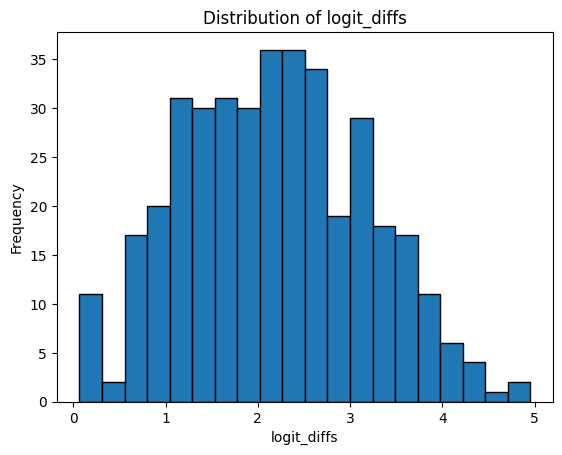

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# random words permuted interval

In [ ]:
# https://bobbyhadz.com/blog/python-generate-random-word
import random
import requests

def get_list_of_words():
    response = requests.get(
        'https://www.mit.edu/~ecprice/wordlist.10000',
        timeout=10
    )

    string_of_words = response.content.decode('utf-8')

    list_of_words = string_of_words.splitlines()

    return list_of_words

words = get_list_of_words()
print(len(words))

random_word = random.choice(words)
print(random_word)  # 👉️ zoo

10000
relationship


In [ ]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
words = filter_to_single_token(words)
len(words)

3266

In [44]:
import random

def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        for j in range(5):
            # Create a list with the required numbers and random words
            elements = [f"{i}", f"{i+1}", f"{i+2}", f"{i+3}", random.choice(words), random.choice(words), random.choice(words), random.choice(words), random.choice(words)]

            # Shuffle the list to mix numbers and words randomly
            random.shuffle(elements)

            # Join the elements to form a text string
            text = " ".join(elements)

            prompt_dict = {
                'incor': f" {i+3}",
                'text': text,
                'answer': f" {i+4}"
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 501, words)

In [45]:
prompts_list

[{'incor': ' 4', 'text': '4 cost cover 2 3 bet tiny 1 map', 'answer': ' 5'},
 {'incor': ' 4',
  'text': '4 w husband 1 status 3 origin entity 2',
  'answer': ' 5'},
 {'incor': ' 4',
  'text': '2 3 display unique ur 1 classic 4 nor',
  'answer': ' 5'},
 {'incor': ' 4', 'text': '2 4 raise 1 come 3 mia pr locks', 'answer': ' 5'},
 {'incor': ' 4',
  'text': '3 carry relevant 1 common 4 its 2 mi',
  'answer': ' 5'},
 {'incor': ' 5',
  'text': '4 gp 2 armed past dose 3 filename 5',
  'answer': ' 6'},
 {'incor': ' 5',
  'text': '2 try led bound protected 4 3 ping 5',
  'answer': ' 6'},
 {'incor': ' 5',
  'text': '3 4 tests 2 5 ethnic wash ict container',
  'answer': ' 6'},
 {'incor': ' 5',
  'text': 'ic independent 3 holy 2 enable cell 4 5',
  'answer': ' 6'},
 {'incor': ' 5',
  'text': '5 tn driving 3 washer pace cigarette 4 2',
  'answer': ' 6'},
 {'incor': ' 6', 'text': '4 6 stick jury 3 5 mi shake ae', 'answer': ' 7'},
 {'incor': ' 6',
  'text': '4 pay holder 5 3 security onto runtime 6',

In [46]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    print(f"{prompt} -> {answer}", toks[0])
    if toks[0] == answer:
        # print(f"{prompt} -> {answer}", toks[0])
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt)
        if len(good_prompts) == 10000:
            break

4 cost cover 2 3 bet tiny 1 map ->  5  1
4 w husband 1 status 3 origin entity 2 ->  5  status
2 3 display unique ur 1 classic 4 nor ->  5 wegian
2 4 raise 1 come 3 mia pr locks ->  5  1
3 carry relevant 1 common 4 its 2 mi ->  5 .
4 gp 2 armed past dose 3 filename 5 ->  6  gp
2 try led bound protected 4 3 ping 5 ->  6  3
3 4 tests 2 5 ethnic wash ict container ->  6 

ic independent 3 holy 2 enable cell 4 5 ->  6  6
0
5 tn driving 3 washer pace cigarette 4 2 ->  6 .
4 6 stick jury 3 5 mi shake ae ->  7  3
4 pay holder 5 3 security onto runtime 6 ->  7  4
3 of float 4 parents 5 going 6 oct ->  7 ober
space 4 install due 5 6 3 heat aus ->  7  4
3 avoid special economic conduct killer 5 6 4 ->  7  5
politics 6 ace 7 4 5 grass adult tv ->  8  6
him 7 skip intel 4 provided 5 camera 6 ->  8 

7 4 6 vg used constitutional lace 5 cock ->  8  4
take 6 7 ru button 4 5 rob den ->  8 ier
reads 5 6 shows hash 4 7 illegal ads ->  8  1
7 des 8 inspired query 5 sign gender 6 ->  9  sign
7 6 blue clien

KeyboardInterrupt: ignored

In [ ]:
good_prompts[-10:]

['virtual 429 fighting 430 yellow 431 cod 432 mb',
 'au 429 successfully 430 just 431 safety 432 member',
 'scoring 429 wave 430 get 431 art 432 back',
 'anger 432 news 433 battle 434 tn 435 dh',
 'parts 432 iron 433 center 434 struct 435 mining',
 'reasonable 432 silver 433 record 434 actively 435 nm',
 'sequence 432 rolling 433 acre 434 ww 435 fu',
 'corruption 432 ta 433 vic 434 paper 435 strike',
 'chem 432 heart 433 recorded 434 og 435 ee',
 'match 432 sequence 433 nv 434 mom 435 peace']

Text(0.5, 1.0, 'Distribution of logit_diffs')

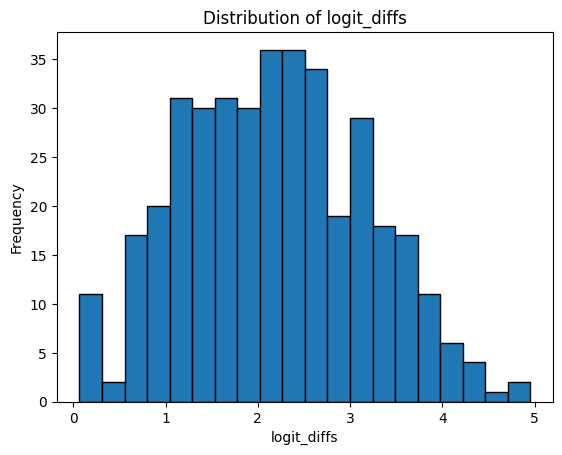

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# random words same interval and keep on prob

In [ ]:
# https://bobbyhadz.com/blog/python-generate-random-word
import random
import requests

def get_list_of_words():
    response = requests.get(
        'https://www.mit.edu/~ecprice/wordlist.10000',
        timeout=10
    )

    string_of_words = response.content.decode('utf-8')

    list_of_words = string_of_words.splitlines()

    return list_of_words

words = get_list_of_words()
print(len(words))

random_word = random.choice(words)
print(random_word)  # 👉️ zoo

10000
relationship


In [ ]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
words = filter_to_single_token(words)
len(words)

3266

In [87]:
def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(30):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': str(i),
                'S2': str(i+1),
                'S3': str(i+2),
                'S4': str(i+3),
                'corr': f" {i+4}",
                'incorr': f" {i+3}",
                'text': f"{rand_words[0]} {i} {rand_words[1]} {i+1} {rand_words[2]} {i+2} {rand_words[3]} {i+3} {rand_words[4]}",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 501, words)

In [88]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    if toks[0] == answer and probs[0] > 0.5 and probs[1] < 0.1:
        # print(f"{prompt} -> {answer}")
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 10000:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: ignored

In [89]:
good_prompts

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'pick 1 historic 2 rack 3 affected 4 offensive'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'gay 1 alias 2 hist 3 bath 4 dollar'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'commercial 1 lib 2 bag 3 mind 4 white'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'sh 1 ian 2 fast 3 fat 4 inline'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'chan 1 un 2 trained 3 order 4 border'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'meaning 1 union 2 selling 3 journal 4 running'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'sum 2 mn 3 gently 4 ton 5 nuts'},
 {'S1': '2',
  'S2': '3',
  'S3': '4

In [73]:
probs

tensor([0.2480, 0.0632, 0.0353, 0.0323, 0.0261, 0.0229, 0.0219, 0.0202, 0.0172,
        0.0143], device='cuda:0')

Text(0.5, 1.0, 'Distribution of logit_diffs')

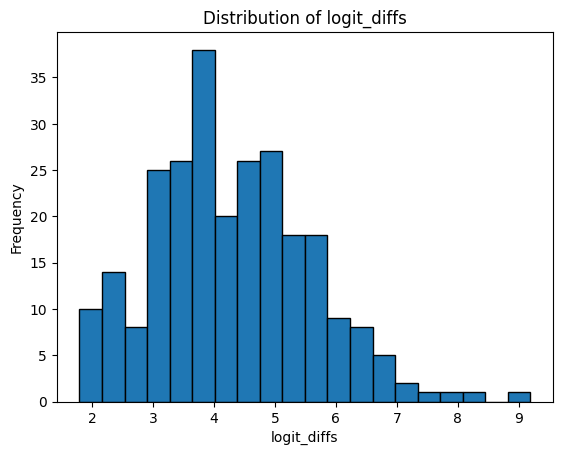

In [74]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')